In [6]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("seaborn-white")
mpl.rcParams['figure.figsize']=(8,6)
import scipy.constants as cst
from lammpsrun import LAMMPS, Prism
import os, sys, shutil

from ase import Atoms
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

import pandas as pd
import seaborn as sns

# homepath = "G:\\home\\LAMMPS_Simulation\\"
hpc_path = "G:\\home\\LAMMPS_Simulation\\HPC_Jupyter\\"
ephemeral_path = "G:\\ephemeral\\"
# ephemeral_path = "/local/yiming/Desktop/yx6015/ephemeral/"
# print(homepath + '\n' + hpc_path)

In [29]:
Fe_aq_names =  ['Fe_aq_imm_efields_0MVcm', 'Fe_aq_imm_efields_20MVcm', 'Fe_aq_imm_efields_30MVcm', 'Fe_aq_imm_efields_40MVcm', 'Fe_aq_imm_efields_50MVcm']
Fe_aq_out = ['56625.pbs', '56626.pbs', '56627.pbs', '56628.pbs', '56629.pbs'] 

In [104]:
traj_lists = []
bonds_list = []
connectivity_list = []
for name, outdir in zip(Fe_aq_names, Fe_aq_out):
    bonds_list.append(os.path.join(ephemeral_path, outdir, "bonds_atoms.hdf5"))
    connectivity_list.append(os.path.join(ephemeral_path, outdir, "bonds_connectivity.hdf5"))
    traj_lists.append(Trajectory(os.path.join(ephemeral_path, outdir, name+".traj"), 'r'))

In [4]:
log_dfs = []
log_reader = LAMMPS()
for outdir in Fe_aq_out:
    log_path = os.path.join(ephemeral_path, outdir, "log.lammps")
    log_reader.read_lammps_log(log_path)
    traj_df = pd.DataFrame(log_reader.thermo_content)
    traj_df.set_index('step', inplace=True)
    log_dfs.append(traj_df)

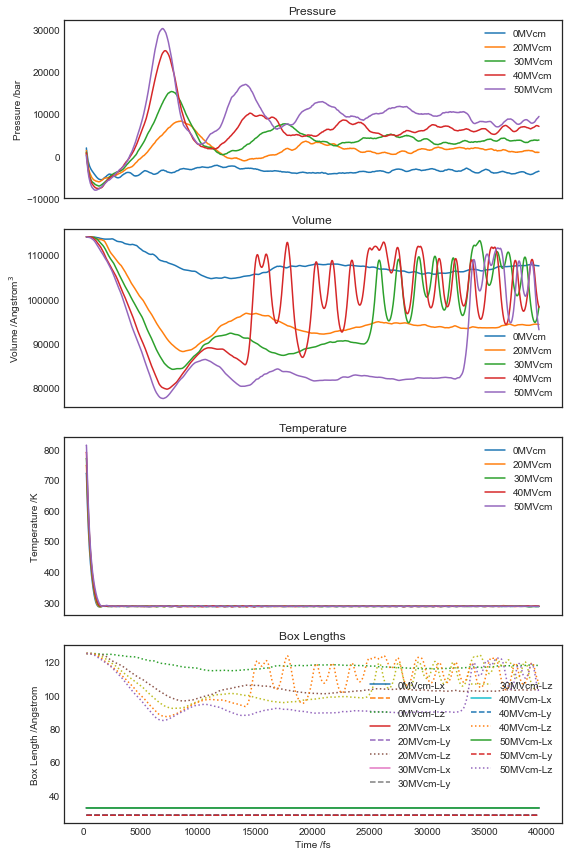

In [22]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(8, 12))
ax1.set_title('Pressure')
ax2.set_title('Volume')
ax3.set_title('Temperature')
ax4.set_title('Box Lengths')

for df, name in zip(log_dfs, [x.split('_')[-1] for x in Fe_aq_names]):
    ax1.plot(df.index/10, df.press.rolling(5000, center=True).mean(), label = name)
    ax2.plot(df.index/10, df.vol.rolling(5000, center=True).mean(), label = name)
    ax3.plot(df.index/10, df.temp.rolling(5000, center=True).mean(), label = name)
    
    ax4.plot(df.index/10, df.lx.rolling(5000, center=True).mean(), label = name+'-Lx', ls = '-')
    ax4.plot(df.index/10, df.ly.rolling(5000, center=True).mean(), label = name+'-Ly', ls = '--')
    ax4.plot(df.index/10, df.lz.rolling(5000, center=True).mean(), label = name+'-Lz', ls = ':')

ax1.set_ylabel("Pressure /bar")
ax2.set_ylabel("Volume /Angstrom$^3$")
ax3.set_ylabel("Temperature /K")
ax4.set_ylabel("Box Length /Angstrom")
ax4.set_xlabel("Time /fs")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend(ncol=2)
f.tight_layout()
plt.show()

## Collate Prior Data

In [105]:
sim_list = {'trajectory': traj_lists,
            'log_df': log_dfs,
            'names': [x.split('_')[-1] for x in Fe_aq_names],
            'bonds_list': bonds_list,
            'connectivity_list': connectivity_list,
            'symbols': np.array(traj_lists[0][0].symbols)}

## Location of Atoms

In [113]:
steps_to_read

array([     0,    400,    800,   1201,   1601,   2002,   2402,   2802,
         3203,   3603,   4004,   4404,   4805,   5205,   5605,   6006,
         6406,   6807,   7207,   7608,   8008,   8408,   8809,   9209,
         9610,  10010,  10411,  10811,  11211,  11612,  12012,  12413,
        12813,  13214,  13614,  14014,  14415,  14815,  15216,  15616,
        16017,  16417,  16817,  17218,  17618,  18019,  18419,  18820,
        19220,  19620,  20021,  20421,  20822,  21222,  21623,  22023,
        22423,  22824,  23224,  23625,  24025,  24426,  24826,  25226,
        25627,  26027,  26428,  26828,  27229,  27629,  28029,  28430,
        28830,  29231,  29631,  30032,  30432,  30832,  31233,  31633,
        32034,  32434,  32835,  33235,  33635,  34036,  34436,  34837,
        35237,  35638,  36038,  36438,  36839,  37239,  37640,  38040,
        38441,  38841,  39241,  39642,  40042,  40443,  40843,  41244,
        41644,  42044,  42445,  42845,  43246,  43646,  44047,  44447,
      

In [106]:
# positions_z = []
# for traj in sim_list['trajectory']:
#     steps_to_read = np.linspace(0, len(traj)-1, 1000, dtype=int)
#     positions_z.append(np.array([traj[t].get_positions().astype(np.float32)[:, 2] for t in steps_to_read]))
# # Savinng binary somewhere
# np.save(file='Fe_aq_imm_pos_z', arr=positions_z)
# # Loading binary
sim_list['positions_z']=np.load('Fe_aq_imm_pos_z.npy')

## Saving Binary Somewhere

## Visualization

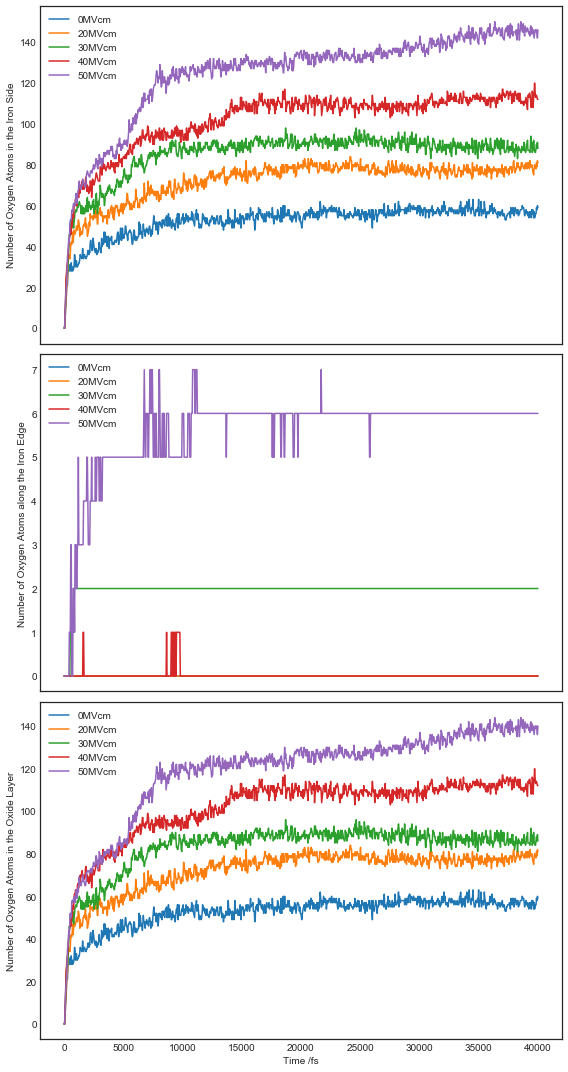

In [125]:
upper_cut_off = 97
lower_cut_off = 7

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 15), sharex=True)
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc= np.percentile(Fe_pos_z, [lower_cut_off, upper_cut_off], axis = 1)
    
    O_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(O_pos_z, Fe_perc[1])])
    O_below_lower = np.array([np.count_nonzero(i < j) for i, j in zip(O_pos_z, Fe_perc[0])])
    O_middle = O_below_upper - O_below_lower
    
    ax1.plot(steps_to_read/10, O_below_upper, label = name)
    ax2.plot(steps_to_read/10, O_below_lower, label = name)
    ax3.plot(steps_to_read/10, O_middle, label = name)

ax1.set_ylabel("Number of Oxygen Atoms in the Iron Side")
ax2.set_ylabel("Number of Oxygen Atoms along the Iron Edge")
ax3.set_ylabel("Number of Oxygen Atoms in the Oxide Layer")

ax3.set_xlabel("Time /fs")

for ax in [ax1, ax2, ax3]:
    ax.legend()

f.tight_layout()
f.savefig("fe_aq_oxygen_distribution.png", dpi=400, )
plt.show()

## Distribution Histogram

### For Iron Atoms

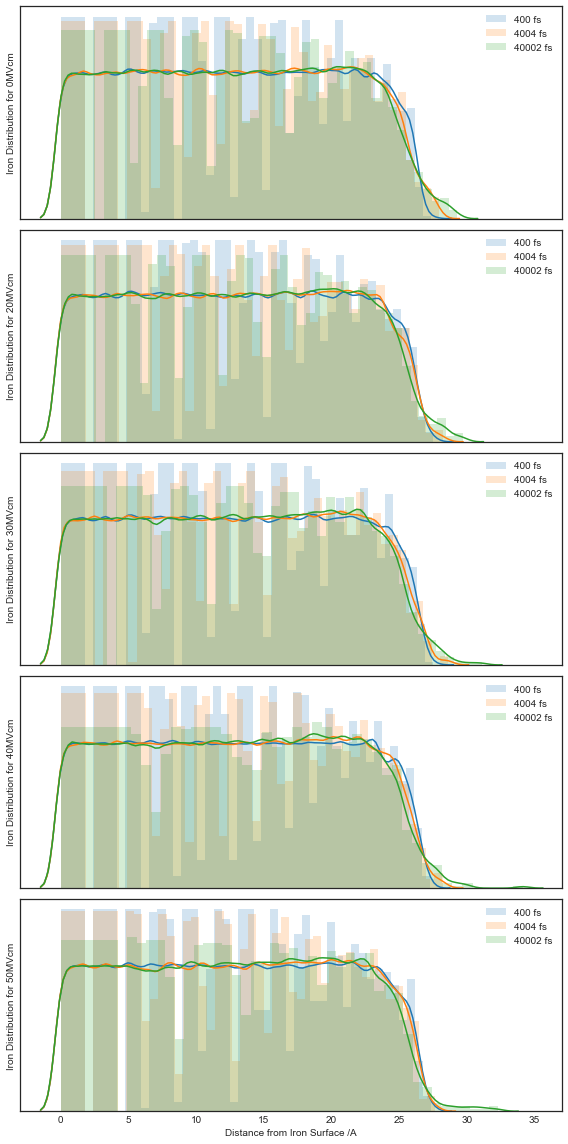

In [121]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 16), sharex=True)
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    Fe_lower = np.min(Fe_pos_z, axis = 1)
    Fe_delta = np.array([i-j for i, j in zip(Fe_pos_z, Fe_lower)])
    
    sns.distplot(Fe_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]//10))
    sns.distplot(Fe_delta[100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]//10))
    sns.distplot(Fe_delta[1000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]//10))
    ax1.set_xlim(-3, 37)
    ax1.set_ylabel("Iron Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')
    
f.tight_layout()
f.savefig("fe_aq_iron_histogram.png", dpi=400)
plt.show()

### For Oxygen Atoms

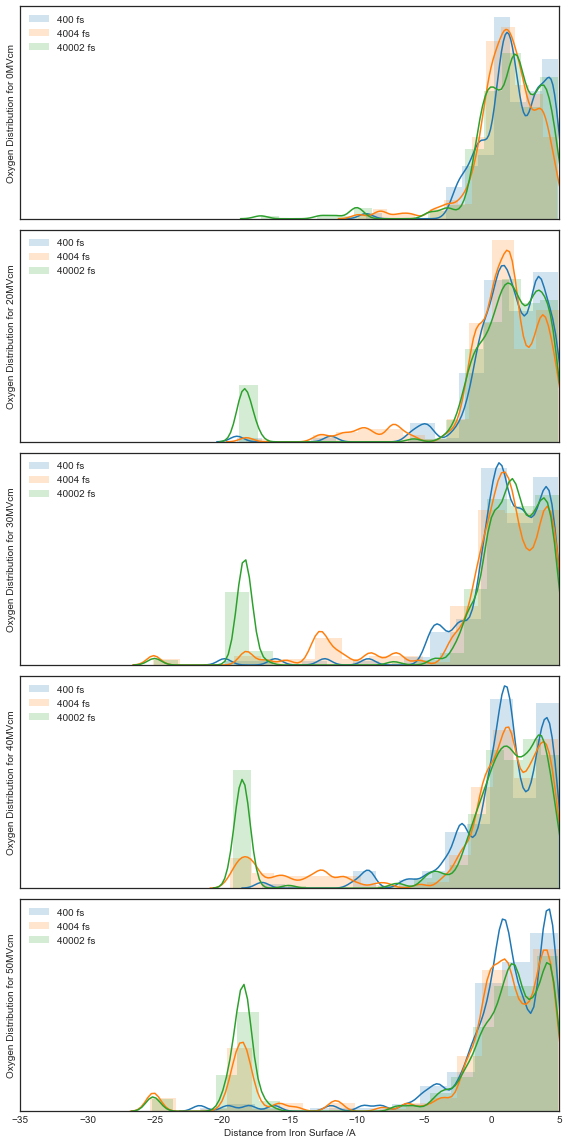

In [124]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 16), sharex=True)
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc_upper = np.percentile(Fe_pos_z, 97, axis = 1)
    
    O_delta = np.array([i[i < j+5]-j for i, j in zip(O_pos_z, Fe_perc_upper)])
    
    sns.distplot(O_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]//10))
    sns.distplot(O_delta[100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]//10))
    sns.distplot(O_delta[1000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]//10))
    ax1.set_xlim(-35, 5)
    ax1.set_ylabel("Oxygen Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')

f.tight_layout()
f.savefig("fe_aq_oxygen_histogram.png", dpi=400)
plt.show()

## Charge of Various Species

In [102]:
from ase.visualize.plot import plot_atoms
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu,
                           norm=mpl.colors.Normalize(vmin=-1., vmax=0.5))
sm.set_array([])

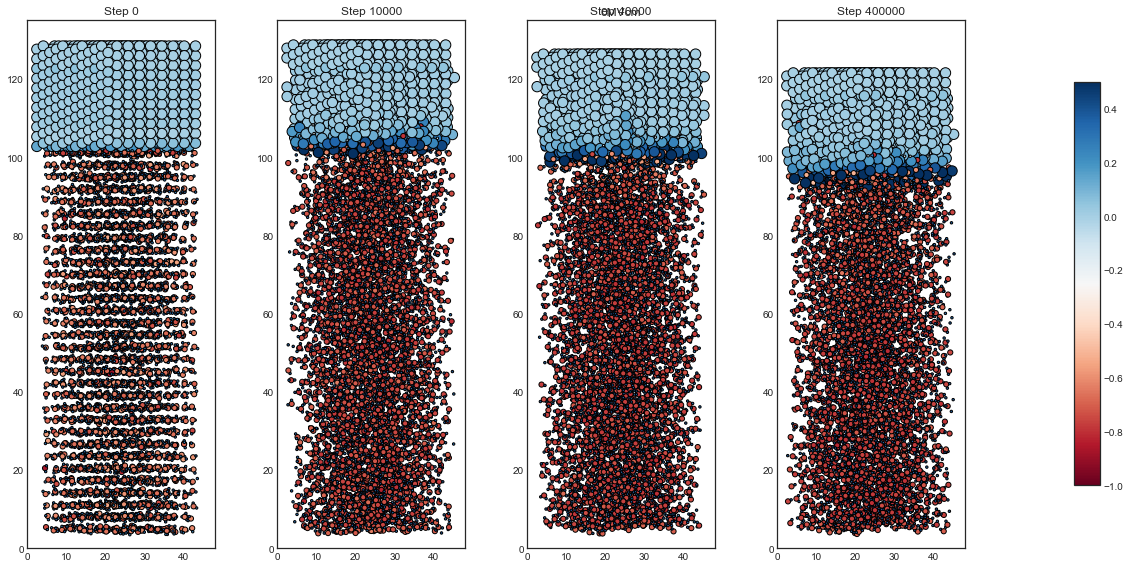

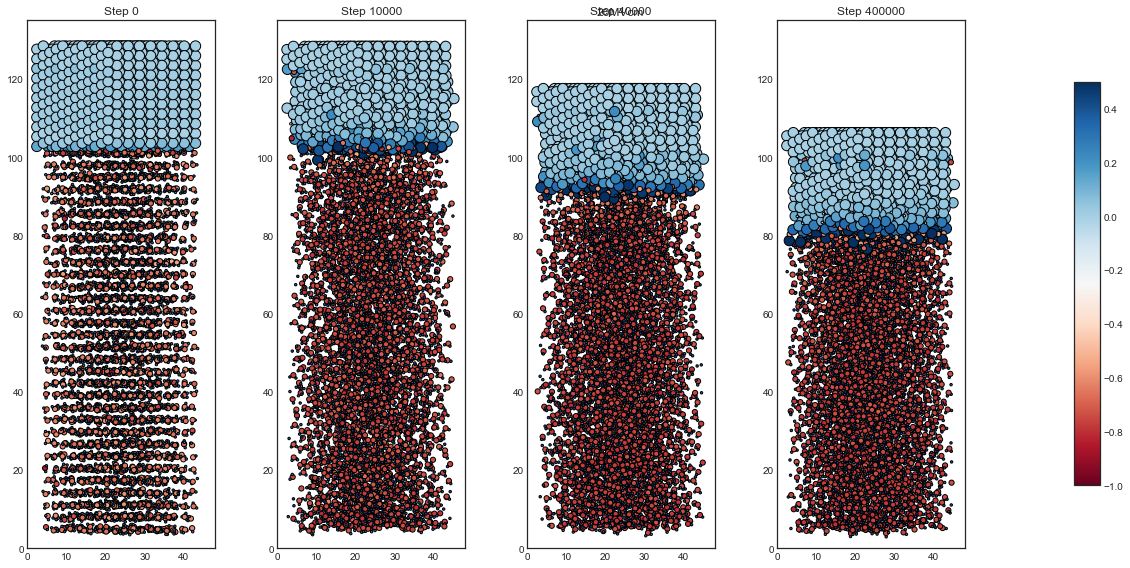

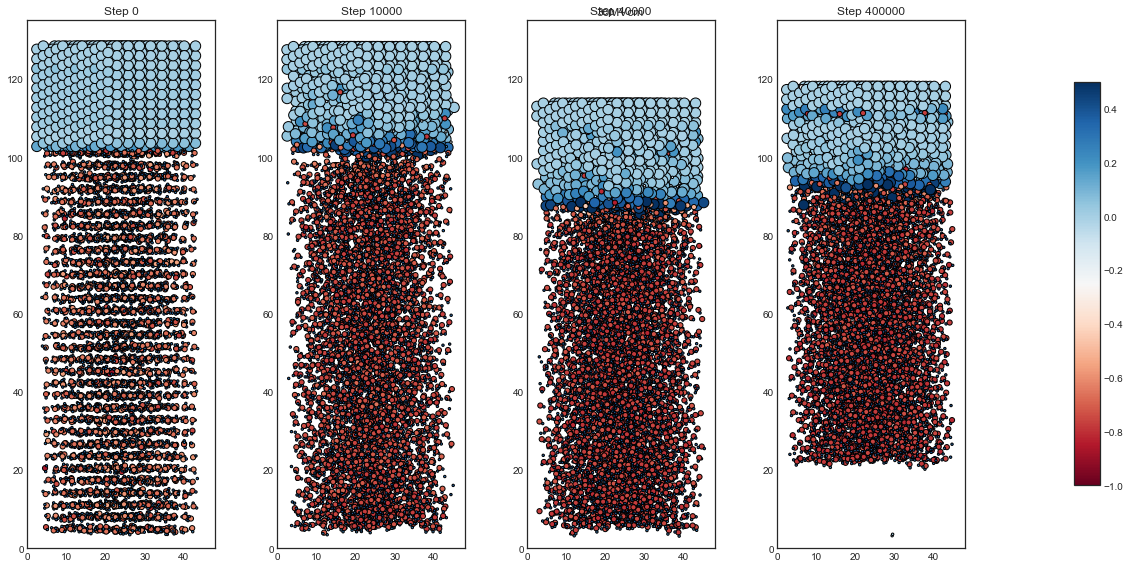

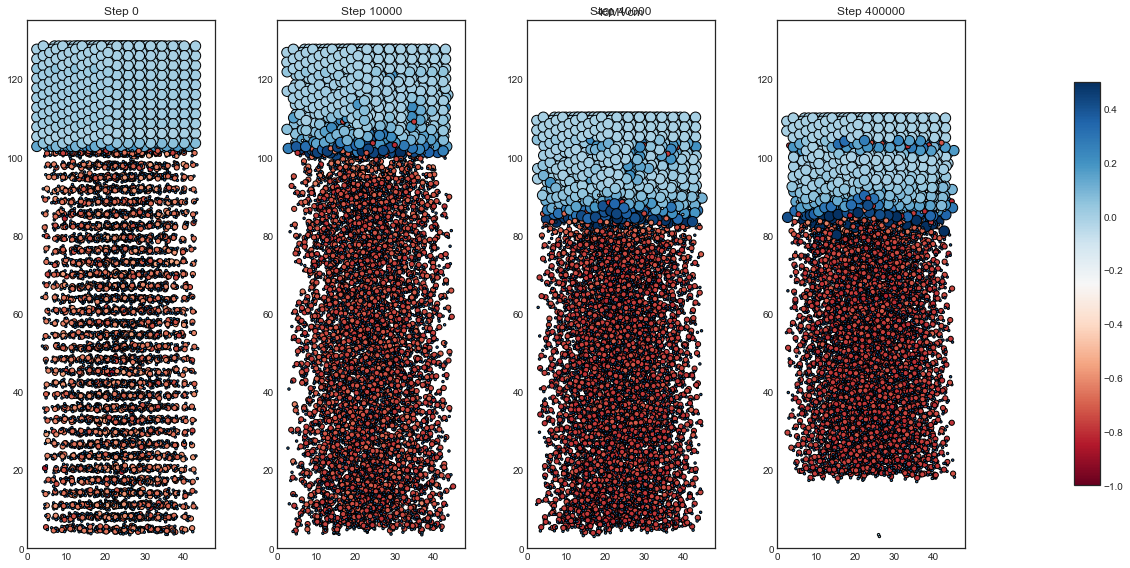

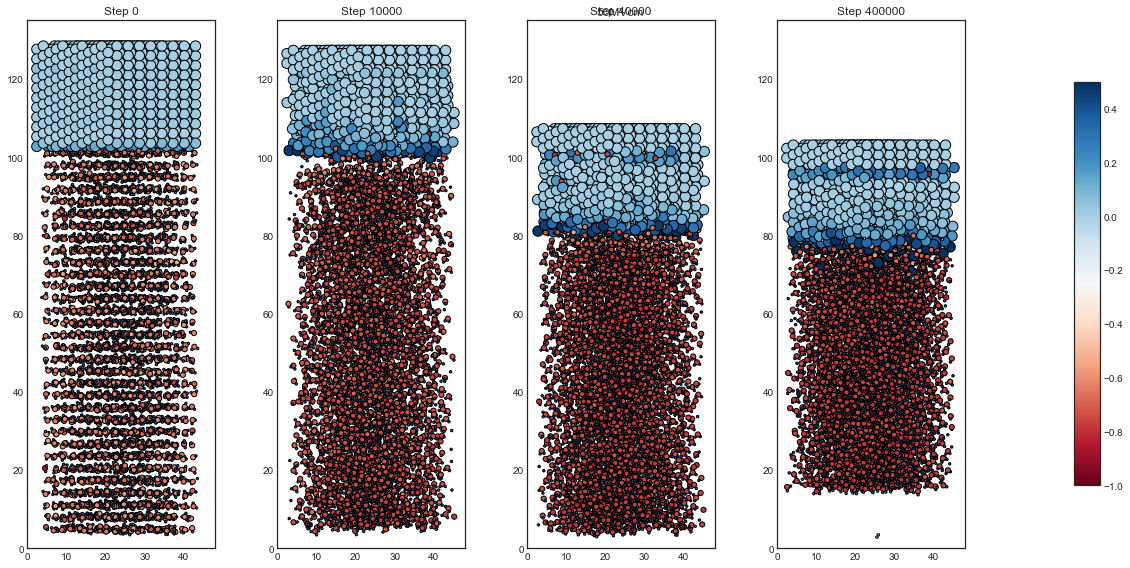

In [107]:
for traj, name, bl in zip(sim_list['trajectory'], sim_list['names'], sim_list['bonds_list']):
    f, ax_arr = plt.subplots(1, 4, figsize=(18, 8))
    
    for ax, step in zip(ax_arr, [0, 10000, 40000, 400000]):
        atom_df = pd.read_hdf(bl, key = 'step{}'.format(step//10))
        atom_color = sm.to_rgba(atom_df.charge)
        plot_atoms(traj[step], colors=atom_color, rotation=('90x, 45y, 0z'), ax=ax)
        ax.set_xlim(0, 48)
        ax.set_ylim(0, 135)
        ax.set_title('Step {}'.format(step))
        
    f.suptitle(name)
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
    f.colorbar(sm, cax=cbar_ax)
    
plt.show()

## Iron RDF

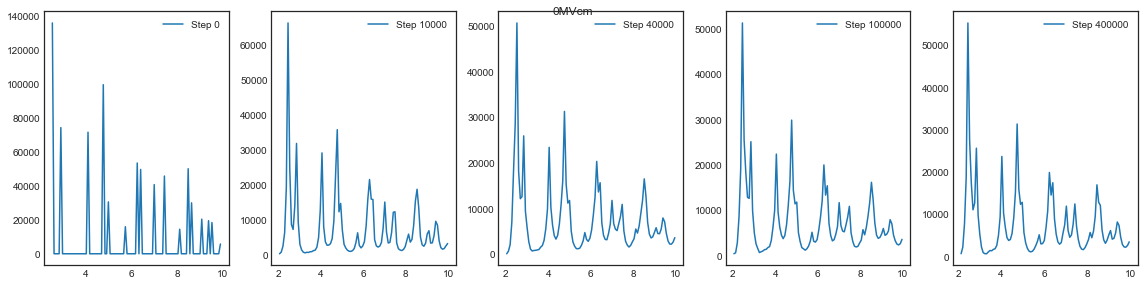

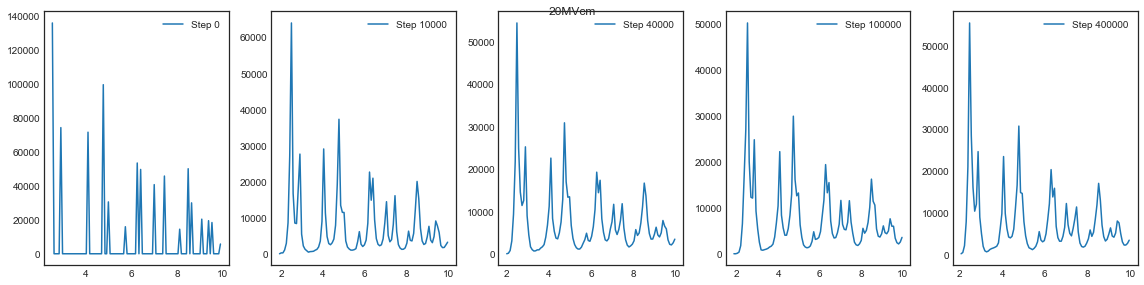

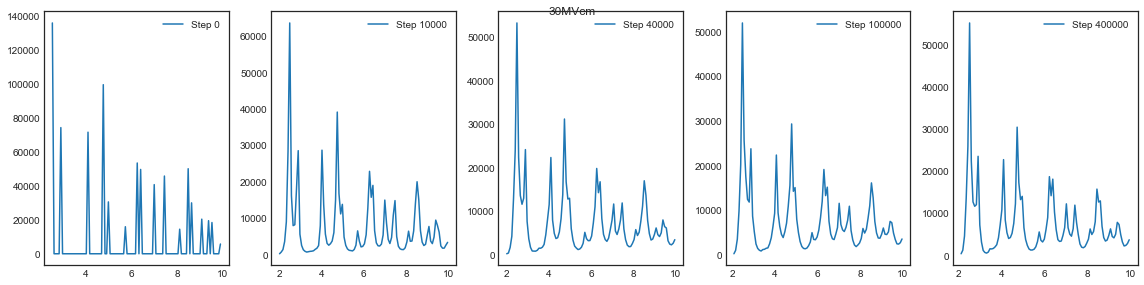

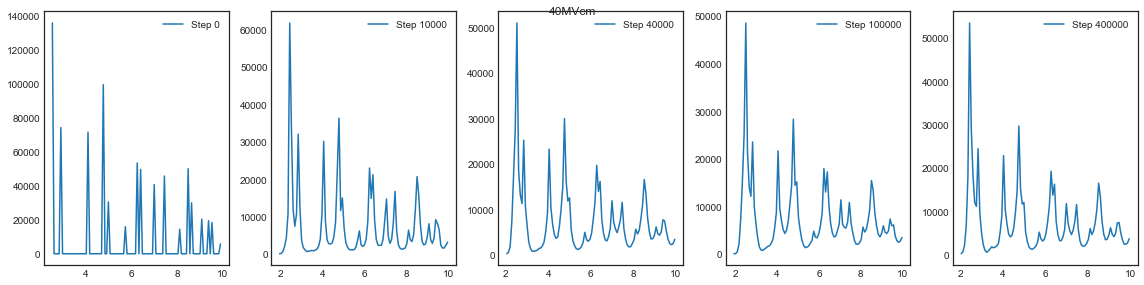

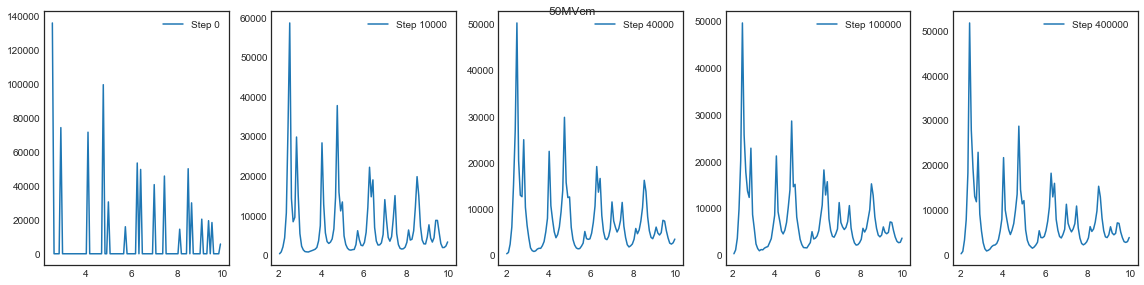

In [112]:
from ase.neighborlist import neighbor_list
for traj, name in zip(sim_list['trajectory'], sim_list['names']):
    f, ax_arr = plt.subplots(1, 5, figsize=(16, 4))
    
    for ax, step in zip(ax_arr, [0, 10000, 40000, 100000, 400000]):
        fe_only = traj[step][sim_list['symbols'] == 'Fe']
        d = neighbor_list('d', fe_only, 10.00)
        h, bin_edges = np.histogram(d, bins=100)
        pdf = h/(4*np.pi/3*(bin_edges[1:]**3 - bin_edges[:-1]**3)) * fe_only.get_volume()/len(fe_only)
        x_axis = (bin_edges[1: ] + bin_edges[:-1])/2
        
        ax.plot(x_axis, pdf, label = 'Step {}'.format(step))
        ax.legend()
    f.suptitle(name)
    f.tight_layout()
    
plt.show()

## Backup Animation Production and Saving

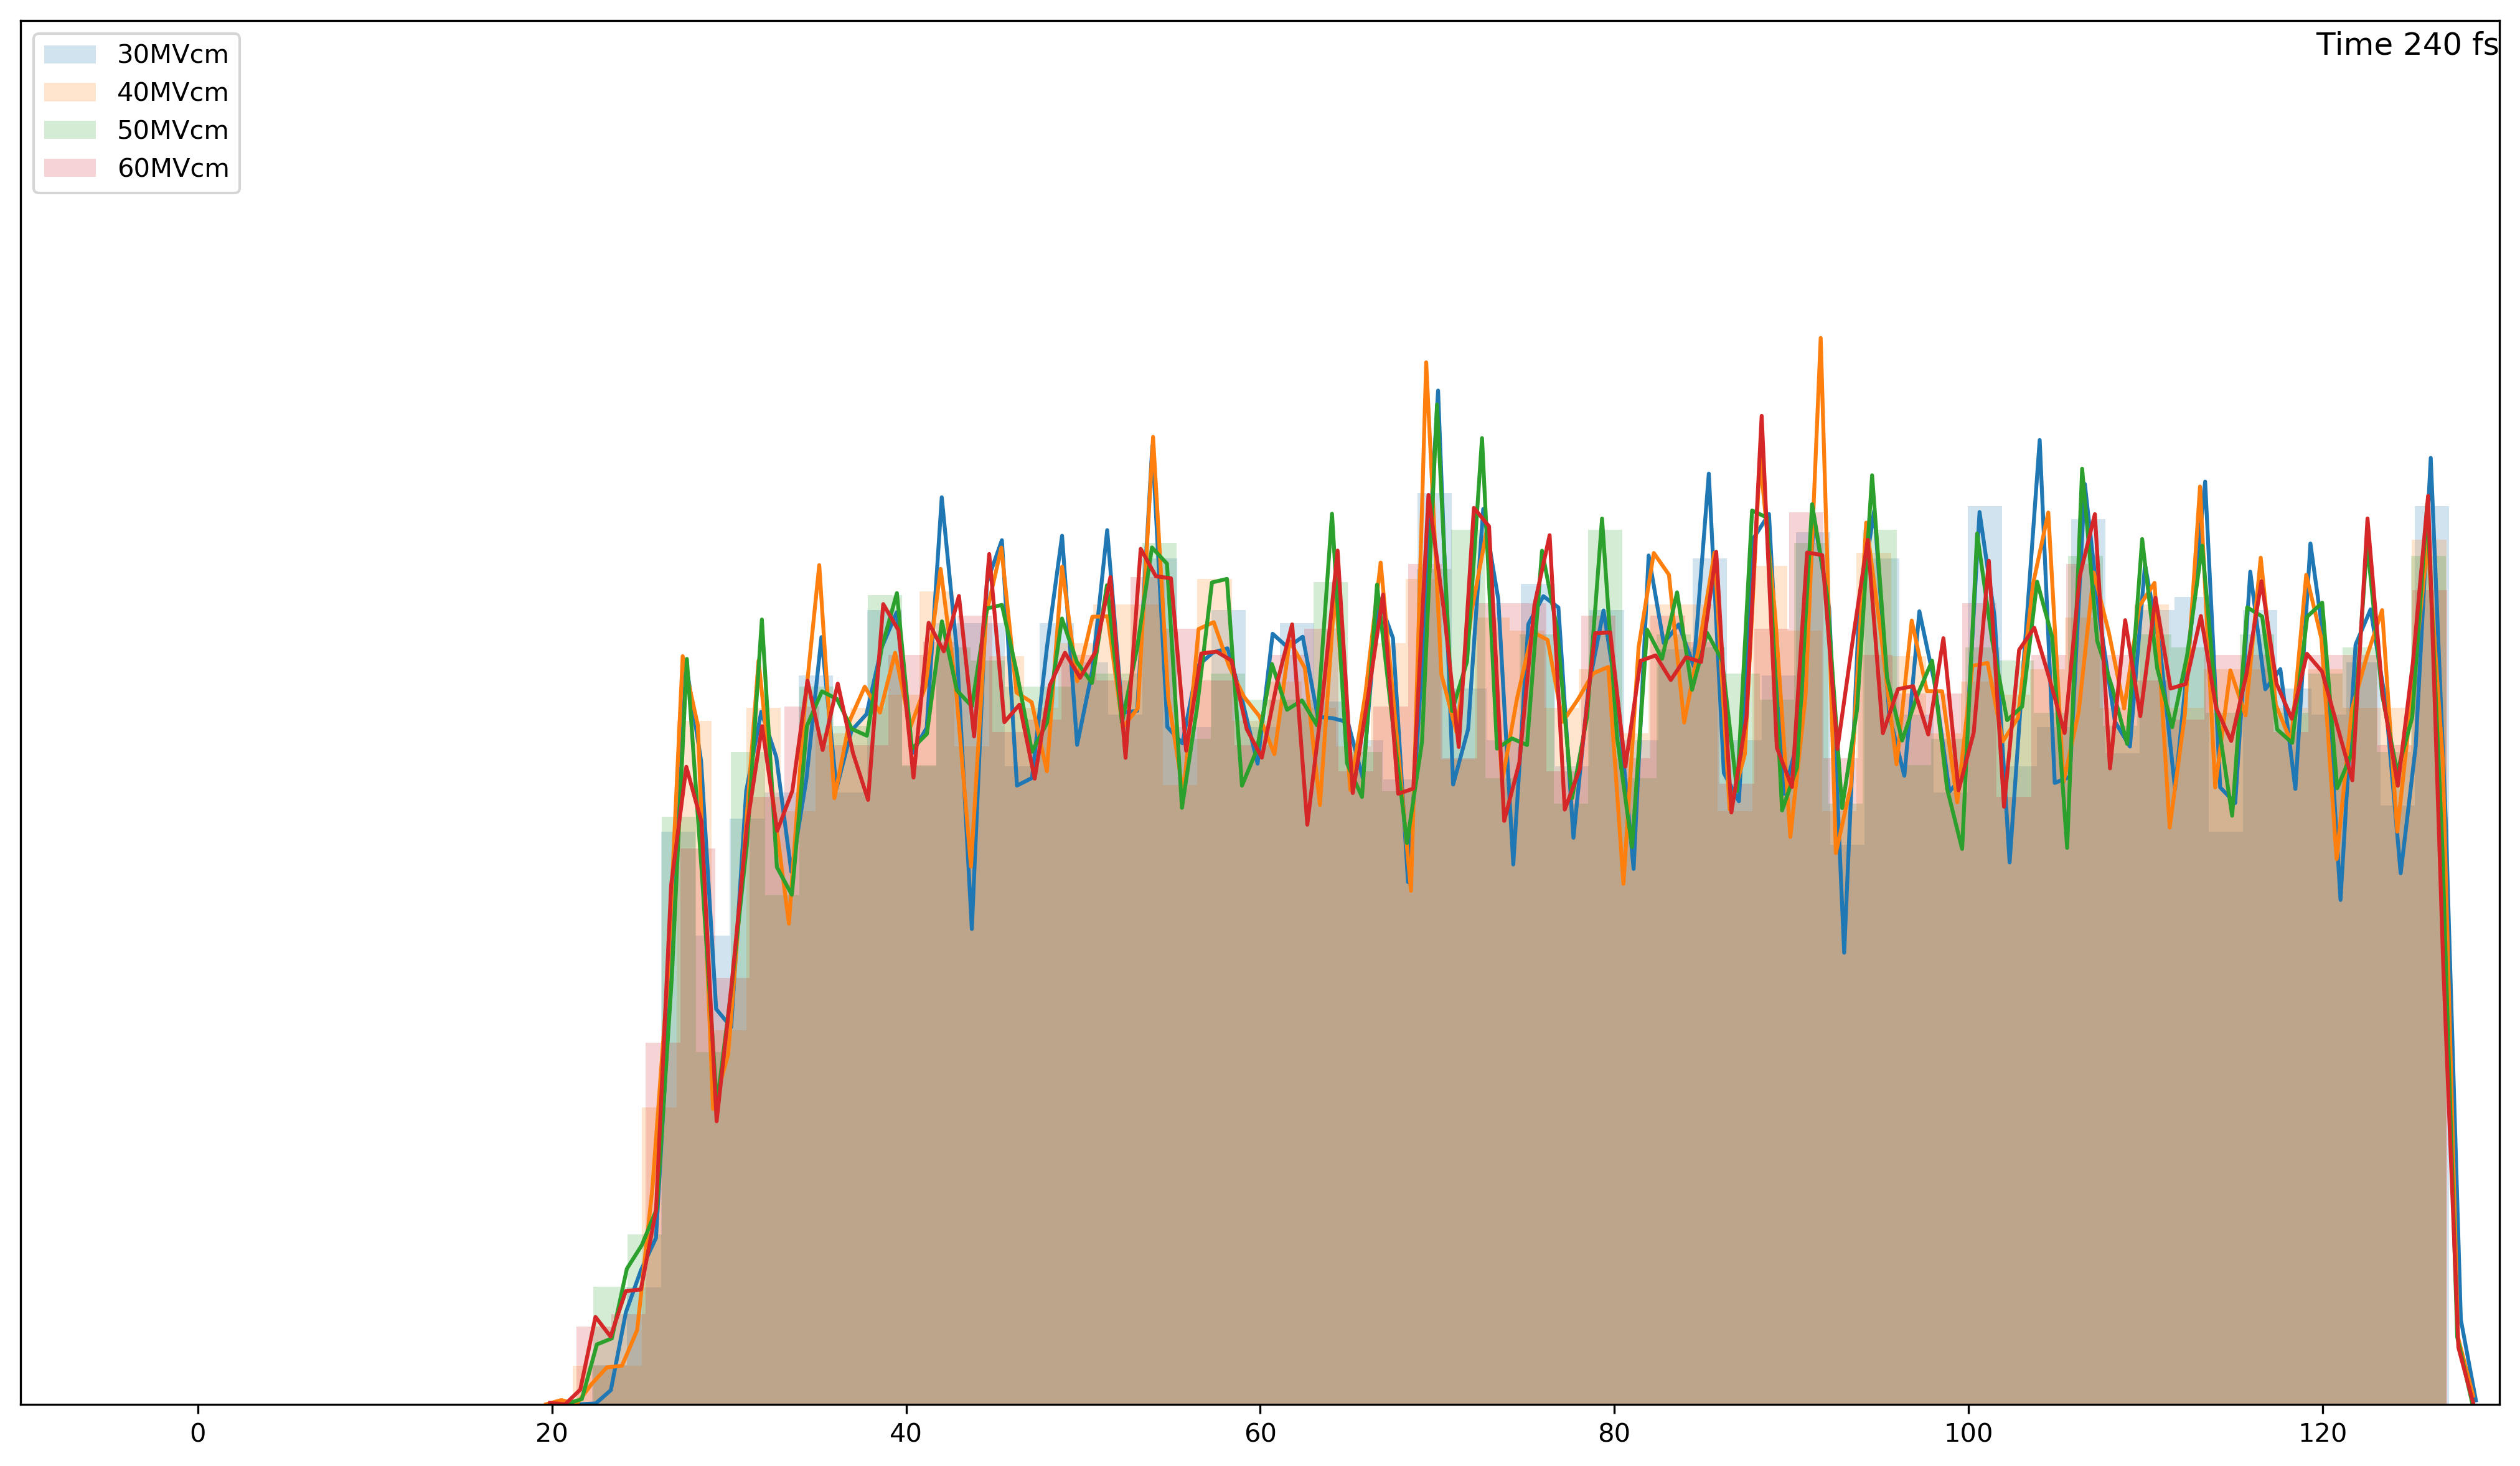

In [125]:
import subprocess

def testSubprocess(outf='testSubprocess.mp4', nframes=1):

    #set up the figure
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.tight_layout()
    fig.set_dpi(300)
    canvas_width, canvas_height = fig.canvas.get_width_height()
    
    # First frame
    ax.tick_params(labelleft=False, left=False)
    sns.kdeplot([], ax = ax)
    ax.set_xlim(-10, 130)
    ax.set_ylim(0, 0.019)

    def update(num):
            ax.clear()
            sns.distplot(sim_list['O_pos_z'][0][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][0])
            sns.distplot(sim_list['O_pos_z'][1][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][1])
            sns.distplot(sim_list['O_pos_z'][2][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][2])
            sns.distplot(sim_list['O_pos_z'][3][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][3])
            ax.set_title('Time {} fs'.format(num*10), loc='right', pad=-13)
            ax.set_xlim(-10, 130)
            ax.set_ylim(0, 0.019)
            ax.legend(loc=2)

    # Open an ffmpeg process
    cmdstring = ('/local/yiming/miniconda3/bin/ffmpeg', 
                 '-y', '-r', '25', # overwrite
                 '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
                 '-pix_fmt', 'argb', # format
                 '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
                 '-crf', '20',
                 '-vcodec', 'libx264', outf) # output encoding
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

    # Draw frames and write to the pipe
    for frame in range(nframes):
        # draw the frame
        update(frame)
        fig.canvas.draw()

        # extract the image as an ARGB string
        string = fig.canvas.tostring_argb()

        # write to pipe
        p.stdin.write(string)

    # Finish up
    p.communicate()

testSubprocess(outf='Fe_H2O_efield.mp4', nframes=len(sim_list['O_pos_z'][0]))

## Pair Distribution Function

Pair distribution function of Fe-O 

## Temperature Difference